Variantas: pasirinktas modelis - GoogleNet.

Klasių rinkinys: Zebras (zebra), Medūza (jellyfish), Žąsis(goose).

Nuotraukų įkėlimui naudojame OpenImages biblioteką.

In [ ]:
!pip install openimages

Įkeliame OpenImages biblioteką ir kitas bibliotekas, reikalingas dirbti su
duomenų nuskaitymu ir pasirinktu modeliu.

In [66]:
import torch
from torchvision import datasets
from torchvision.transforms import transforms
import numpy as np
from torchvision import models
import PIL

import os
from openimages.download import download_dataset

Tikriname, ar veikia GPU. Jei veikia, viskas gerai, jei ne, naudojame CPU.

In [67]:
torch.cuda.is_available()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Nustatome aplanko pavadinimą, nuotraukų kiekį klasėje ir klasių pavadinimus. Klasių ID imti iš https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

In [82]:
data_dir = "data"
number_of_samples = 600
classes = ["Goose", "Zebra", "Jellyfish"]
class_ids = [99, 340, 107]

Sukuriamas aplankas nuotraukoms.

In [83]:
if not os.path.exists(data_dir):
    os.makedirs(data_dir)


Jos atsisiunčiamos.

In [ ]:
print("Downloading is starting...")
download_dataset(data_dir, classes, limit=number_of_samples)

Padaromi pakeitimai nuotraukoms, kad galima būtų jas pateikti GoogLeNet modeliui. Kodas rašytas atsižvelgiant į GoogleNet dokumentaciją.

In [85]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=PIL.Image.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Nurodoma, kad duomenų aibės klasė (dataset) bus nuotraukų aplankas 'data'

In [86]:
dataset = datasets.ImageFolder(root='/content/data', transform=transform)

Užkraunamas pirmasis nuotraukų rinkinys (batch) į duomenų paruošėją (data loader)

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

model = models.googlenet(pretrained = True).to(device)
model.eval()

 Funkcija `class_statistics` yra skirta apskaičiuoti klasifikacijos metrikas. Ji taiko nustatytą slenkstinę vertę (threshold), kad pakeistų numatytas tikimybes į dvejetainius sprendimus (tiesa/netiesa) - 1, jei tikimybė yra didesnė už slenkstį, ir 0 - jei mažesnė.
Tada, remiantis šiais dvejetainiais sprendimais ir tikrųjų žymenų reikšmėmis, apskaičiuojamas tikslumas, atkūrimas, precizija ir F1 reikšmės.

In [88]:
def class_statistics(ground_truth, predictions, threshold):
    # Palygina numatytas tikimybes su slenkstine verte ir paverčia jas į dvejetainius rezultatus
    predictions_thresholded = predictions > threshold

    # Teisingai Teigiami (TP): tikri ir numatyti atvejai kaip teigiami
    # Teisingai Neigiami (TN): tikri ir numatyti atvejai kaip neigiami
    # Klaidingai Teigiami (FP): tikri atvejai yra neigiami, bet numatyti kaip teigiami
    # Klaidingai Neigiami (FN): tikri atvejai yra teigiami, bet numatyti kaip neigiami

    TP = np.sum((ground_truth == 1) & (predictions_thresholded == True))
    TN = np.sum((ground_truth == 0) & (predictions_thresholded == False))
    FP = np.sum((ground_truth == 0) & (predictions_thresholded == True))
    FN = np.sum((ground_truth == 1) & (predictions_thresholded == False))

    # Apskaičiuoja tikslumą kaip teisingai nuspėtų atvejų dalį iš visų atvejų
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Apskaičiuoja atpažinimo tikslumą (recall) kaip teisingai teigiamų atvejų dalį iš visų tikrųjų teigiamų atvejų
    recall = TP / (TP + FN)
    # Apskaičiuoja preciziją kaip teisingai teigiamų atvejų dalį iš visų teigiamai nuspėtų atvejų
    precision = TP / (TP + FP)
    # Apskaičiuoja F1 įvertis kaip dviejų kartų precizijos ir atpažinimo tikslumo harmoninis vidurkis
    f1 = 2 * (precision * recall) / (precision + recall)

    return {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1
    }

Kitos funkcijos

In [89]:
# Sukuria sąrašą porų (tikimybė, tiesa), kur tikimybė yra konkrečios klasės tikimybė iš modelio prognozės
def calculate_probability(probabilities, class_id, label_arr, class_label):
    return [(probabilities[i][class_id],
             float(label_arr[i] == class_label)) for i in range(len(label_arr))]

# Iš sąrašo porų (tikimybė, tiesa) išrenka ir grąžina tik tikimybės reikšmes
def get_probability(array):
    return [probability for probability, _ in array]

# Iš sąrašo porų (tikimybė, tiesa) išrenka ir grąžina tik tiesos reikšmes
def get_truth(arr):
    return [truth for _, truth in arr]

# Iš sąrašo porų gauna tikrųjų žymų ir tikimybių sąrašus
def calculate_statistics(probabilities, threshold):
  truth_list = get_truth(probabilities)
  probabilities_list = get_probability(probabilities)

  # Apskaičiuoja klasifikacijos metrikas pagal gautas tikrųjų žymų ir tikimybių sąrašus bei nurodytą slenkstinę vertę
  return class_statistics(np.array(truth_list),
                           np.array(probabilities_list),
                           threshold)

Slenkstinė reikšmė

In [90]:
thresholds = [0.50, 0.50, 0.50]

Statistikos apskaičiavimas

In [91]:
# Spausdina statistikos rezultatus kiekvienai klasei
def print_statistics(label, results):
    print(f"\nStatistics for {label}:")
    print(f"Accuracy: {results['accuracy']}")
    print(f"Recall: {results['recall']}")
    print(f"Precision: {results['precision']}")
    print(f"F1 Score: {results['f1']}")

# Sukuria žodyną kiekvienai klasei saugoti jų tikimybėms
class_probabilities = {label: [] for label in classes}

# Iteruoja per duomenų pakrovimo generatorių ir apdoroja vaizdus
for images, labels in data_loader:
  images, labels = images.cuda(), labels.cuda() # Perkelia vaizdus ir žymes į CUDA įrenginį
  outputs = model(images)
  probabilities = torch.sigmoid(outputs).detach().cpu().numpy()
  labels_array = labels.cpu().numpy() # Perkelia žymas atgal į NumPy masyvą

  # Iteruoja per kiekvieną klasę ir jų ID
  for label, class_id in zip(classes, class_ids):
    class_probabilities[label].extend(calculate_probability(probabilities, class_id, labels_array, classes.index(label)))

# Skaičiuoja ir spausdina statistiką kiekvienai klasei
for label, threshold in zip(classes, thresholds):
  results = calculate_statistics(class_probabilities[label], threshold)
  print_statistics(label, results)


Statistics for Goose:
Accuracy: 0.3126934984520124
Recall: 0.8888888888888888
Precision: 0.01188707280832095
F1 Score: 0.02346041055718475

Statistics for Zebra:
Accuracy: 0.6697626418988648
Recall: 0.74
Precision: 0.578125
F1 Score: 0.6491228070175439

Statistics for Jellyfish:
Accuracy: 0.9060887512899897
Recall: 1.0
Precision: 0.8063829787234043
F1 Score: 0.8928150765606596


Slenkstinės žymės nustatymas

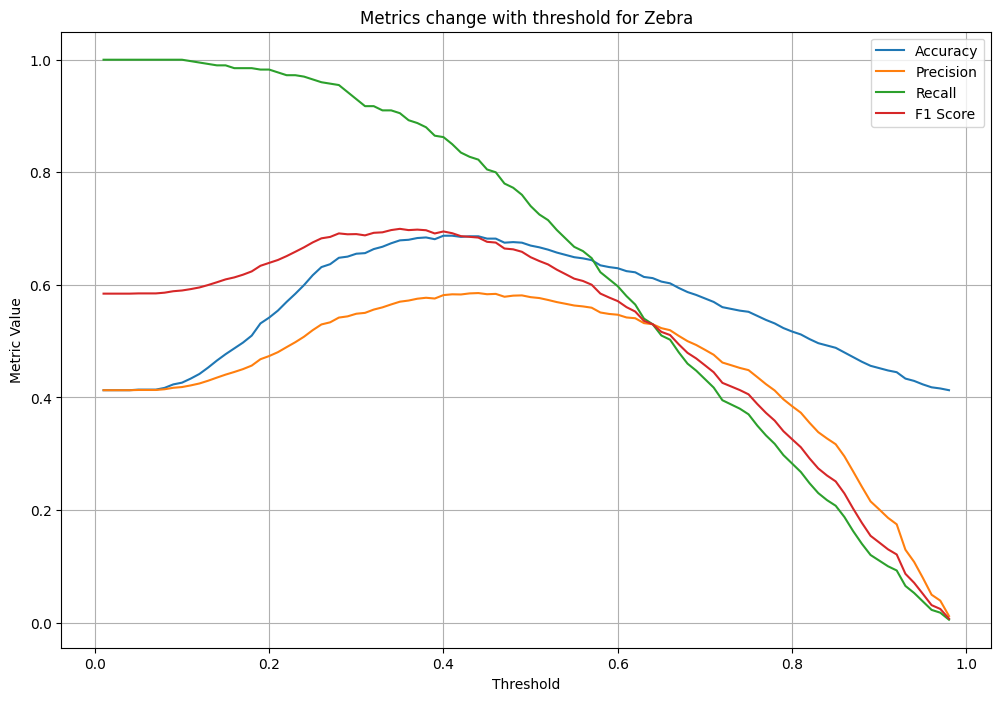

Best Threshold: 0.35000000000000003, with F1 Score: 0.6995169082125604


In [92]:
import matplotlib.pyplot as plt

test_threshold = 0.01
test_class = "Zebra"


thresholds = np.arange(test_threshold, 0.99, 0.01)
accuracies, precisions, recalls, f1s = [], [], [], []

best_threshold = 0
best_f1 = 0

for threshold in thresholds:
  results = calculate_statistics(class_probabilities[test_class], threshold)
  accuracies.append(results['accuracy'])
  precisions.append(results['precision'])
  recalls.append(results['recall'])
  f1 = results['f1']
  f1s.append(results['f1'])

  if f1 > best_f1:
    best_f1 = f1
    best_threshold = threshold

plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title(f'Metrics change with threshold for {test_class}')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Threshold: {best_threshold}, with F1 Score: {best_f1}")